In [1]:
import nengo
import nengo_spa as spa
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [2]:
# Number of dimensions for the Semantic Pointers
dimensions = 32

model = spa.Network(label="Simple question answering")

# Alternate between RED and BLUE as a color
def colour_input(t):
    if (t // 0.5) % 2 == 0:
        return 'RED'
    else:
        return 'BLUE'

# Alternate between CIRCLE AND SQUARE
def shape_input(t):
    if (t // 0.5) % 2 == 0:
        return 'CIRCLE'
    else:
        return 'SQUARE'

# Alternate between any of the four properties as a question/cue
def cue_input(t):
    sequence = ['0', 'CIRCLE', 'RED', '0', 'SQUARE', 'BLUE'] 
    idx = int((t // (1. / len(sequence))) % len(sequence))
    return sequence[idx]


with model:
    colour_in = spa.Transcode(colour_input, output_vocab=dimensions)
    shape_in = spa.Transcode(shape_input, output_vocab=dimensions)
    cue = spa.Transcode(cue_input, output_vocab=dimensions)    
    
    conv = spa.State(dimensions)
    out = spa.State(dimensions)

    # Connect the buffers
    colour_in * shape_in >> conv
    conv * ~cue >> out

    model.config[nengo.Probe].synapse = nengo.Lowpass(0.03)
    p_colour_in = nengo.Probe(colour_in.output)
    p_shape_in = nengo.Probe(shape_in.output)
    p_cue = nengo.Probe(cue.output)
    p_conv = nengo.Probe(conv.output)
    p_out = nengo.Probe(out.output)

In [3]:
with nengo.Simulator(model) as sim:
    sim.run(3.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

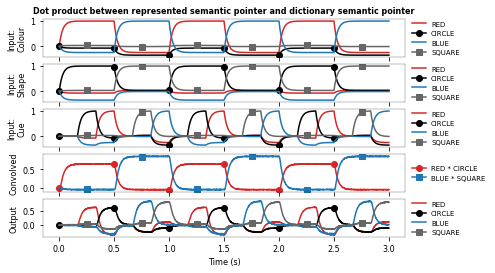

In [4]:
fig, axs = plt.subplots(5, 1, figsize=(6.5, 4), sharex=True)
vocab = model.vocabs[dimensions]

cmap = cm.get_cmap('tab10')
style = [
    {"color": cmap(0.3)},
    {"color": "k", "marker": "o", "markevery": 500},
    {"color": cmap(0.0)},
    {"color": "#666666", "marker": "s", "markevery": (250, 500)}
]
for i in range(4):
    axs[0].plot(sim.trange(), spa.similarity(sim.data[p_colour_in], vocab)[:, i], **style[i])
axs[0].legend(vocab.keys(), fontsize='x-small', loc='center left', bbox_to_anchor=(1.0, 0.5))
axs[0].set_ylabel("Input:\nColour")
axs[0].set_title('Dot product between represented semantic pointer and dictionary semantic pointer')

for i in range(4):
    axs[1].plot(sim.trange(), spa.similarity(sim.data[p_shape_in], vocab)[:, i], **style[i])
axs[1].legend(vocab.keys(), fontsize='x-small', loc='center left', bbox_to_anchor=(1.0, 0.5))
axs[1].set_ylabel("Input:\nShape")

for i in range(4):
    axs[2].plot(sim.trange(), spa.similarity(sim.data[p_cue], vocab)[:, i], **style[i])
axs[2].legend(vocab.keys(), fontsize='x-small', loc='center left', bbox_to_anchor=(1.0, 0.5))
axs[2].set_ylabel("Input:\nCue")

for i in range(4):
    axs[4].plot(sim.trange(), spa.similarity(sim.data[p_out], vocab)[:, i], **style[i])
axs[4].legend(vocab.keys(), fontsize='x-small', loc='center left', bbox_to_anchor=(1.0, 0.5))
axs[4].set_ylabel("Output")
axs[4].set_xlabel("Time (s)");

style = [
    {"color": cmap(0.3), "marker": "o", "markevery": 500},
    {"color": cmap(0.0), "marker": "s", "markevery": (250, 500)}
]
for i, pointer in enumerate(['RED * CIRCLE', 'BLUE * SQUARE']):
    axs[3].plot(sim.trange(), vocab.parse(pointer).dot(sim.data[p_conv].T), label=pointer, **style[i])
axs[3].legend(fontsize='x-small', loc='center left', bbox_to_anchor=(1.0, 0.5))
axs[3].set_ylabel("Convolved")


fig.savefig('../nengo_spa_example.pdf', bbox_inches='tight', transparent=True)